In [1]:
import numpy as np
import tensorflow as tf

# Set seeds
np.random.seed(10)
tf.random.set_seed(10)

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, Reshape, Flatten
from tensorflow.keras.layers import Conv1D, TimeDistributed, UpSampling1D, MaxPooling1D
from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model

### Some global variables

In [2]:
Rnum = 1000
x = np.linspace(0.0,1.0,num=128)
dx = 1.0/np.shape(x)[0]
tsteps = np.linspace(0.0,2.0,num=400)
dt = 2.0/np.shape(tsteps)[0]
mode = 'train'

### Functions for full-order snapshots of Burgers Equation

In [3]:
def exact_solution(Rnum,t):
    t0 = np.exp(Rnum/8.0)

    return (x/(t+1))/(1.0+np.sqrt((t+1)/t0)*np.exp(Rnum*(x*x)/(4.0*t+4)))

def collect_snapshots(Rnum):
    snapshot_matrix = np.zeros(shape=(np.shape(x)[0],np.shape(tsteps)[0]))

    trange = np.arange(np.shape(tsteps)[0])
    for t in trange:
        snapshot_matrix[:,t] = exact_solution(Rnum,tsteps[t])[:]

    return np.transpose(snapshot_matrix)

### Collect some snapshot data for CNN-LSTM embedding

In [4]:
snapshots_train = collect_snapshots(Rnum)
snapshots_train = np.expand_dims(snapshots_train,-1)

### Do some shifting for evolution predictions

In [5]:
snapshots_evolve = snapshots_train[1:]
snapshots_train = snapshots_train[0:-1]

### ML related presets

In [6]:
weights_filepath = 'best_weights.h5'
lrate = 0.001

def coeff_determination(y_pred, y_true): #Order of function inputs is important here        
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

### Autoencoder and LSTM

In [7]:
# Encoder
encoder_inputs = Input(shape=(128,1),name='Field')

x = Conv1D(25,kernel_size=3,activation='swish',padding='same')(encoder_inputs)
enc_l2 = MaxPooling1D(2,padding='same')(x)

x = Conv1D(15,kernel_size=3,activation='swish',padding='same')(enc_l2)
enc_l3 = MaxPooling1D(2,padding='same')(x)

x = Conv1D(10,kernel_size=3,activation='swish',padding='same')(enc_l3)
enc_l4 = MaxPooling1D(2,padding='same')(x)

x = Conv1D(5,kernel_size=3,activation='swish',padding='same')(enc_l4)
enc_l5 = MaxPooling1D(2,padding='same')(x)

x = Flatten()(enc_l5)
x = Dense(8,activation='swish')(x)
x = Dense(4,activation='swish')(x)
encoded = Dense(2,activation='linear')(x)

# LSTM
lstm_inputs = Reshape((1,2))(encoded)
x = LSTM(40,return_sequences=True)(lstm_inputs)
lstm_outputs = Dense(2,activation=None)(x)

# Decoder architecture (shared)
dec_layer_1 = Flatten()
dec_layer_2 = Dense(2,activation='swish')
dec_layer_3 = Dense(4,activation='swish')
dec_layer_4 = Dense(8,activation='linear')
dec_layer_5 = Reshape((8,1))

dec_layer_6 = Conv1D(5,kernel_size=3,activation='swish',padding='same')
dec_layer_7 = Conv1D(10,kernel_size=3,activation='swish',padding='same')
dec_layer_8 = Conv1D(15,kernel_size=3,activation='swish',padding='same')
dec_layer_9 = Conv1D(20,kernel_size=3,activation='swish',padding='same')
dec_layer_10 = Conv1D(1,kernel_size=3,activation=None,padding='same')

# Decoder - using LSTM
x = dec_layer_1(lstm_outputs)
x = dec_layer_2(x)
x = dec_layer_3(x)
x = dec_layer_4(x)
x = dec_layer_5(x)

x = dec_layer_6(x)
x = UpSampling1D(2)(x)

x = dec_layer_7(x)
x = UpSampling1D(2)(x)

x = dec_layer_8(x)
x = UpSampling1D(2)(x)

x = dec_layer_9(x)
x = UpSampling1D(2)(x)

lstm_decoder_outputs = dec_layer_10(x)

# Decoder - using AE only
x = dec_layer_1(encoded)
x = dec_layer_2(x)
x = dec_layer_3(x)
x = dec_layer_4(x)
x = dec_layer_5(x)

x = dec_layer_6(x)
x = UpSampling1D(2)(x)

x = dec_layer_7(x)
x = UpSampling1D(2)(x)

x = dec_layer_8(x)
x = UpSampling1D(2)(x)

x = dec_layer_9(x)
x = UpSampling1D(2)(x)

ae_decoder_outputs = dec_layer_10(x)

# Compile model
model = Model(inputs=[encoder_inputs],outputs=[ae_decoder_outputs,lstm_decoder_outputs],name='CAE-LSTM')
   
# design network
my_adam = optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

checkpoint = ModelCheckpoint(weights_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint]

# fit network
model.compile(optimizer=my_adam,loss='mean_squared_error',metrics=[coeff_determination],loss_weights=[1.0,0.0])    
model.summary()

num_epochs = 500
batch_size = 4

if mode == 'train':
    train_history = model.fit(x=snapshots_train, 
                              y=[snapshots_train,snapshots_evolve], 
                              epochs=num_epochs, 
                              batch_size=batch_size, 
                              callbacks=callbacks_list,
                              validation_split=0.1)

Model: "CAE-LSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Field (InputLayer)              [(None, 128, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 128, 25)      100         Field[0][0]                      
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 64, 25)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 64, 15)       1140        max_pooling1d[0][0]              
___________________________________________________________________________________________

79/90 [=========================>....] - ETA: 0s - loss: 0.0137 - conv1d_8_loss: 0.0137 - conv1d_8_1_loss: 0.0136 - conv1d_8_coeff_determination: -2035380.2500 - conv1d_8_1_coeff_determination: -2056707.2500
Epoch 00001: loss improved from inf to 0.01289, saving model to best_weights.h5
90/90 [==============================] - 1s 11ms/step - loss: 0.0129 - conv1d_8_loss: 0.0129 - conv1d_8_1_loss: 0.0128 - conv1d_8_coeff_determination: -1786611.5000 - conv1d_8_1_coeff_determination: -1805331.8750 - val_loss: 0.0096 - val_conv1d_8_loss: 0.0096 - val_conv1d_8_1_loss: 0.0086 - val_conv1d_8_coeff_determination: -0.4055 - val_conv1d_8_1_coeff_determination: -0.4782
Epoch 2/500
90/90 [==============================] - ETA: 0s - loss: 0.0052 - conv1d_8_loss: 0.0052 - conv1d_8_1_loss: 0.0062 - conv1d_8_coeff_determination: 0.4141 - conv1d_8_1_coeff_determination: 0.1640
Epoch 00002: loss improved from 0.01289 to 0.00522, saving model to best_weights.h5
90/90 [==============================] - 1

Epoch 14/500
77/90 [========================>.....] - ETA: 0s - loss: 0.0012 - conv1d_8_loss: 0.0012 - conv1d_8_1_loss: 0.0070 - conv1d_8_coeff_determination: 0.9084 - conv1d_8_1_coeff_determination: 0.1419
Epoch 00014: loss improved from 0.00125 to 0.00123, saving model to best_weights.h5
90/90 [==============================] - 0s 4ms/step - loss: 0.0012 - conv1d_8_loss: 0.0012 - conv1d_8_1_loss: 0.0068 - conv1d_8_coeff_determination: 0.9088 - conv1d_8_1_coeff_determination: 0.1725 - val_loss: 0.0025 - val_conv1d_8_loss: 0.0025 - val_conv1d_8_1_loss: 0.0060 - val_conv1d_8_coeff_determination: 0.7210 - val_conv1d_8_1_coeff_determination: 0.2590
Epoch 15/500
79/90 [=========================>....] - ETA: 0s - loss: 0.0012 - conv1d_8_loss: 0.0012 - conv1d_8_1_loss: 0.0068 - conv1d_8_coeff_determination: 0.9121 - conv1d_8_1_coeff_determination: 0.1645
Epoch 00015: loss improved from 0.00123 to 0.00119, saving model to best_weights.h5
90/90 [==============================] - 0s 5ms/step - 

83/90 [==========================>...] - ETA: 0s - loss: 5.2634e-04 - conv1d_8_loss: 5.2634e-04 - conv1d_8_1_loss: 0.0070 - conv1d_8_coeff_determination: 0.9628 - conv1d_8_1_coeff_determination: 0.3257
Epoch 00026: loss improved from 0.00054 to 0.00053, saving model to best_weights.h5
90/90 [==============================] - 1s 6ms/step - loss: 5.2766e-04 - conv1d_8_loss: 5.2766e-04 - conv1d_8_1_loss: 0.0071 - conv1d_8_coeff_determination: 0.9628 - conv1d_8_1_coeff_determination: 0.3149 - val_loss: 0.0021 - val_conv1d_8_loss: 0.0021 - val_conv1d_8_1_loss: 0.0100 - val_conv1d_8_coeff_determination: 0.7661 - val_conv1d_8_1_coeff_determination: 0.0250
Epoch 27/500
83/90 [==========================>...] - ETA: 0s - loss: 5.2543e-04 - conv1d_8_loss: 5.2543e-04 - conv1d_8_1_loss: 0.0073 - conv1d_8_coeff_determination: 0.9633 - conv1d_8_1_coeff_determination: 0.3065
Epoch 00027: loss improved from 0.00053 to 0.00052, saving model to best_weights.h5
90/90 [==============================] - 0s 

88/90 [============================>.] - ETA: 0s - loss: 3.7707e-04 - conv1d_8_loss: 3.7707e-04 - conv1d_8_1_loss: 0.0071 - conv1d_8_coeff_determination: 0.9735 - conv1d_8_1_coeff_determination: 0.3572
Epoch 00038: loss did not improve from 0.00037
90/90 [==============================] - 0s 5ms/step - loss: 3.7758e-04 - conv1d_8_loss: 3.7758e-04 - conv1d_8_1_loss: 0.0071 - conv1d_8_coeff_determination: 0.9735 - conv1d_8_1_coeff_determination: 0.3497 - val_loss: 0.0020 - val_conv1d_8_loss: 0.0020 - val_conv1d_8_1_loss: 0.0114 - val_conv1d_8_coeff_determination: 0.7904 - val_conv1d_8_1_coeff_determination: -0.0079
Epoch 39/500
89/90 [============================>.] - ETA: 0s - loss: 3.5453e-04 - conv1d_8_loss: 3.5453e-04 - conv1d_8_1_loss: 0.0071 - conv1d_8_coeff_determination: 0.9751 - conv1d_8_1_coeff_determination: 0.3529
Epoch 00039: loss improved from 0.00037 to 0.00035, saving model to best_weights.h5
90/90 [==============================] - 0s 5ms/step - loss: 3.5472e-04 - conv1d

Epoch 51/500
83/90 [==========================>...] - ETA: 0s - loss: 2.6513e-04 - conv1d_8_loss: 2.6513e-04 - conv1d_8_1_loss: 0.0074 - conv1d_8_coeff_determination: 0.9816 - conv1d_8_1_coeff_determination: 0.3351
Epoch 00051: loss improved from 0.00027 to 0.00026, saving model to best_weights.h5
90/90 [==============================] - 0s 5ms/step - loss: 2.6375e-04 - conv1d_8_loss: 2.6375e-04 - conv1d_8_1_loss: 0.0074 - conv1d_8_coeff_determination: 0.9817 - conv1d_8_1_coeff_determination: 0.3351 - val_loss: 0.0019 - val_conv1d_8_loss: 0.0019 - val_conv1d_8_1_loss: 0.0111 - val_conv1d_8_coeff_determination: 0.7942 - val_conv1d_8_1_coeff_determination: -0.0029
Epoch 52/500
78/90 [=========================>....] - ETA: 0s - loss: 2.7944e-04 - conv1d_8_loss: 2.7944e-04 - conv1d_8_1_loss: 0.0075 - conv1d_8_coeff_determination: 0.9809 - conv1d_8_1_coeff_determination: 0.3314
Epoch 00052: loss did not improve from 0.00026
90/90 [==============================] - 0s 5ms/step - loss: 2.7796

Epoch 64/500
90/90 [==============================] - ETA: 0s - loss: 2.0336e-04 - conv1d_8_loss: 2.0336e-04 - conv1d_8_1_loss: 0.0078 - conv1d_8_coeff_determination: 0.9861 - conv1d_8_1_coeff_determination: 0.3013
Epoch 00064: loss improved from 0.00021 to 0.00020, saving model to best_weights.h5
90/90 [==============================] - 0s 6ms/step - loss: 2.0336e-04 - conv1d_8_loss: 2.0336e-04 - conv1d_8_1_loss: 0.0078 - conv1d_8_coeff_determination: 0.9861 - conv1d_8_1_coeff_determination: 0.3013 - val_loss: 0.0016 - val_conv1d_8_loss: 0.0016 - val_conv1d_8_1_loss: 0.0104 - val_conv1d_8_coeff_determination: 0.8272 - val_conv1d_8_1_coeff_determination: 0.0644
Epoch 65/500
86/90 [===========================>..] - ETA: 0s - loss: 2.0199e-04 - conv1d_8_loss: 2.0199e-04 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9862 - conv1d_8_1_coeff_determination: 0.3050
Epoch 00065: loss improved from 0.00020 to 0.00020, saving model to best_weights.h5
90/90 [========================

Epoch 77/500
83/90 [==========================>...] - ETA: 0s - loss: 1.4510e-04 - conv1d_8_loss: 1.4510e-04 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9901 - conv1d_8_1_coeff_determination: 0.2819
Epoch 00077: loss improved from 0.00015 to 0.00014, saving model to best_weights.h5
90/90 [==============================] - 0s 5ms/step - loss: 1.4483e-04 - conv1d_8_loss: 1.4483e-04 - conv1d_8_1_loss: 0.0075 - conv1d_8_coeff_determination: 0.9902 - conv1d_8_1_coeff_determination: 0.2863 - val_loss: 0.0016 - val_conv1d_8_loss: 0.0016 - val_conv1d_8_1_loss: 0.0102 - val_conv1d_8_coeff_determination: 0.8207 - val_conv1d_8_1_coeff_determination: 0.0206
Epoch 78/500
83/90 [==========================>...] - ETA: 0s - loss: 1.4946e-04 - conv1d_8_loss: 1.4946e-04 - conv1d_8_1_loss: 0.0074 - conv1d_8_coeff_determination: 0.9899 - conv1d_8_1_coeff_determination: 0.3003
Epoch 00078: loss did not improve from 0.00014
90/90 [==============================] - 0s 5ms/step - loss: 1.4981e

Epoch 90/500
84/90 [===========================>..] - ETA: 0s - loss: 1.1338e-04 - conv1d_8_loss: 1.1338e-04 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9923 - conv1d_8_1_coeff_determination: 0.2749
Epoch 00090: loss did not improve from 0.00010
90/90 [==============================] - 0s 5ms/step - loss: 1.1112e-04 - conv1d_8_loss: 1.1112e-04 - conv1d_8_1_loss: 0.0075 - conv1d_8_coeff_determination: 0.9925 - conv1d_8_1_coeff_determination: 0.2935 - val_loss: 0.0016 - val_conv1d_8_loss: 0.0016 - val_conv1d_8_1_loss: 0.0105 - val_conv1d_8_coeff_determination: 0.8218 - val_conv1d_8_1_coeff_determination: 0.0259
Epoch 91/500
85/90 [===========================>..] - ETA: 0s - loss: 1.0097e-04 - conv1d_8_loss: 1.0097e-04 - conv1d_8_1_loss: 0.0074 - conv1d_8_coeff_determination: 0.9932 - conv1d_8_1_coeff_determination: 0.2939
Epoch 00091: loss improved from 0.00010 to 0.00010, saving model to best_weights.h5
90/90 [==============================] - 0s 5ms/step - loss: 1.0198e

Epoch 103/500
83/90 [==========================>...] - ETA: 0s - loss: 1.0084e-04 - conv1d_8_loss: 1.0084e-04 - conv1d_8_1_loss: 0.0075 - conv1d_8_coeff_determination: 0.9932 - conv1d_8_1_coeff_determination: 0.2784
Epoch 00103: loss did not improve from 0.00008
90/90 [==============================] - 1s 6ms/step - loss: 9.8089e-05 - conv1d_8_loss: 9.8089e-05 - conv1d_8_1_loss: 0.0075 - conv1d_8_coeff_determination: 0.9934 - conv1d_8_1_coeff_determination: 0.2866 - val_loss: 0.0013 - val_conv1d_8_loss: 0.0013 - val_conv1d_8_1_loss: 0.0104 - val_conv1d_8_coeff_determination: 0.8571 - val_conv1d_8_1_coeff_determination: 0.0407
Epoch 104/500
89/90 [============================>.] - ETA: 0s - loss: 7.5837e-05 - conv1d_8_loss: 7.5837e-05 - conv1d_8_1_loss: 0.0075 - conv1d_8_coeff_determination: 0.9949 - conv1d_8_1_coeff_determination: 0.2806
Epoch 00104: loss improved from 0.00008 to 0.00008, saving model to best_weights.h5
90/90 [==============================] - 0s 5ms/step - loss: 7.551

Epoch 116/500
81/90 [==========================>...] - ETA: 0s - loss: 6.5115e-05 - conv1d_8_loss: 6.5115e-05 - conv1d_8_1_loss: 0.0073 - conv1d_8_coeff_determination: 0.9956 - conv1d_8_1_coeff_determination: 0.2823
Epoch 00116: loss did not improve from 0.00006
90/90 [==============================] - 0s 5ms/step - loss: 6.4968e-05 - conv1d_8_loss: 6.4968e-05 - conv1d_8_1_loss: 0.0074 - conv1d_8_coeff_determination: 0.9956 - conv1d_8_1_coeff_determination: 0.2731 - val_loss: 0.0011 - val_conv1d_8_loss: 0.0011 - val_conv1d_8_1_loss: 0.0098 - val_conv1d_8_coeff_determination: 0.8711 - val_conv1d_8_1_coeff_determination: 0.0346
Epoch 117/500
80/90 [=========================>....] - ETA: 0s - loss: 6.4146e-05 - conv1d_8_loss: 6.4146e-05 - conv1d_8_1_loss: 0.0075 - conv1d_8_coeff_determination: 0.9958 - conv1d_8_1_coeff_determination: 0.2685
Epoch 00117: loss did not improve from 0.00006
90/90 [==============================] - 0s 5ms/step - loss: 6.3742e-05 - conv1d_8_loss: 6.3742e-05 - c

Epoch 129/500
82/90 [==========================>...] - ETA: 0s - loss: 4.9850e-05 - conv1d_8_loss: 4.9850e-05 - conv1d_8_1_loss: 0.0073 - conv1d_8_coeff_determination: 0.9966 - conv1d_8_1_coeff_determination: 0.2732
Epoch 00129: loss did not improve from 0.00004
90/90 [==============================] - 0s 5ms/step - loss: 5.0223e-05 - conv1d_8_loss: 5.0223e-05 - conv1d_8_1_loss: 0.0074 - conv1d_8_coeff_determination: 0.9966 - conv1d_8_1_coeff_determination: 0.2579 - val_loss: 9.7479e-04 - val_conv1d_8_loss: 9.7479e-04 - val_conv1d_8_1_loss: 0.0095 - val_conv1d_8_coeff_determination: 0.8932 - val_conv1d_8_1_coeff_determination: 0.0700
Epoch 130/500
81/90 [==========================>...] - ETA: 0s - loss: 4.1929e-05 - conv1d_8_loss: 4.1929e-05 - conv1d_8_1_loss: 0.0074 - conv1d_8_coeff_determination: 0.9972 - conv1d_8_1_coeff_determination: 0.2641
Epoch 00130: loss improved from 0.00004 to 0.00004, saving model to best_weights.h5
90/90 [==============================] - 0s 5ms/step - los

Epoch 142/500
78/90 [=========================>....] - ETA: 0s - loss: 5.0248e-05 - conv1d_8_loss: 5.0248e-05 - conv1d_8_1_loss: 0.0074 - conv1d_8_coeff_determination: 0.9966 - conv1d_8_1_coeff_determination: 0.2560
Epoch 00142: loss did not improve from 0.00003
90/90 [==============================] - 0s 5ms/step - loss: 4.9806e-05 - conv1d_8_loss: 4.9806e-05 - conv1d_8_1_loss: 0.0075 - conv1d_8_coeff_determination: 0.9966 - conv1d_8_1_coeff_determination: 0.2474 - val_loss: 7.4270e-04 - val_conv1d_8_loss: 7.4270e-04 - val_conv1d_8_1_loss: 0.0092 - val_conv1d_8_coeff_determination: 0.9160 - val_conv1d_8_1_coeff_determination: 0.0727
Epoch 143/500
81/90 [==========================>...] - ETA: 0s - loss: 3.7531e-05 - conv1d_8_loss: 3.7531e-05 - conv1d_8_1_loss: 0.0074 - conv1d_8_coeff_determination: 0.9975 - conv1d_8_1_coeff_determination: 0.2539
Epoch 00143: loss did not improve from 0.00003
90/90 [==============================] - 0s 5ms/step - loss: 3.7637e-05 - conv1d_8_loss: 3.7637

Epoch 155/500
85/90 [===========================>..] - ETA: 0s - loss: 2.3293e-05 - conv1d_8_loss: 2.3293e-05 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9984 - conv1d_8_1_coeff_determination: 0.2351
Epoch 00155: loss improved from 0.00002 to 0.00002, saving model to best_weights.h5
90/90 [==============================] - 1s 6ms/step - loss: 2.2979e-05 - conv1d_8_loss: 2.2979e-05 - conv1d_8_1_loss: 0.0075 - conv1d_8_coeff_determination: 0.9984 - conv1d_8_1_coeff_determination: 0.2411 - val_loss: 7.8399e-04 - val_conv1d_8_loss: 7.8399e-04 - val_conv1d_8_1_loss: 0.0093 - val_conv1d_8_coeff_determination: 0.9126 - val_conv1d_8_1_coeff_determination: 0.0725
Epoch 156/500
86/90 [===========================>..] - ETA: 0s - loss: 2.1461e-05 - conv1d_8_loss: 2.1461e-05 - conv1d_8_1_loss: 0.0074 - conv1d_8_coeff_determination: 0.9986 - conv1d_8_1_coeff_determination: 0.2492
Epoch 00156: loss improved from 0.00002 to 0.00002, saving model to best_weights.h5
90/90 [==============

Epoch 168/500
81/90 [==========================>...] - ETA: 0s - loss: 2.0789e-05 - conv1d_8_loss: 2.0789e-05 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9986 - conv1d_8_1_coeff_determination: 0.2279
Epoch 00168: loss did not improve from 0.00002
90/90 [==============================] - 0s 4ms/step - loss: 2.0246e-05 - conv1d_8_loss: 2.0246e-05 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9986 - conv1d_8_1_coeff_determination: 0.2395 - val_loss: 7.1723e-04 - val_conv1d_8_loss: 7.1723e-04 - val_conv1d_8_1_loss: 0.0090 - val_conv1d_8_coeff_determination: 0.9202 - val_conv1d_8_1_coeff_determination: 0.0867
Epoch 169/500
90/90 [==============================] - ETA: 0s - loss: 2.1155e-05 - conv1d_8_loss: 2.1155e-05 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9986 - conv1d_8_1_coeff_determination: 0.2409
Epoch 00169: loss did not improve from 0.00002
90/90 [==============================] - 0s 5ms/step - loss: 2.1155e-05 - conv1d_8_loss: 2.1155

Epoch 181/500
89/90 [============================>.] - ETA: 0s - loss: 1.6062e-05 - conv1d_8_loss: 1.6062e-05 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9989 - conv1d_8_1_coeff_determination: 0.2382
Epoch 00181: loss did not improve from 0.00001
90/90 [==============================] - 0s 5ms/step - loss: 1.6051e-05 - conv1d_8_loss: 1.6051e-05 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9989 - conv1d_8_1_coeff_determination: 0.2406 - val_loss: 7.3075e-04 - val_conv1d_8_loss: 7.3075e-04 - val_conv1d_8_1_loss: 0.0090 - val_conv1d_8_coeff_determination: 0.9174 - val_conv1d_8_1_coeff_determination: 0.0880
Epoch 182/500
89/90 [============================>.] - ETA: 0s - loss: 2.5389e-05 - conv1d_8_loss: 2.5389e-05 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9983 - conv1d_8_1_coeff_determination: 0.2327
Epoch 00182: loss did not improve from 0.00001
90/90 [==============================] - 0s 5ms/step - loss: 2.5362e-05 - conv1d_8_loss: 2.5362

Epoch 194/500
88/90 [============================>.] - ETA: 0s - loss: 1.3098e-05 - conv1d_8_loss: 1.3098e-05 - conv1d_8_1_loss: 0.0075 - conv1d_8_coeff_determination: 0.9991 - conv1d_8_1_coeff_determination: 0.2460
Epoch 00194: loss did not improve from 0.00001
90/90 [==============================] - 0s 5ms/step - loss: 1.3076e-05 - conv1d_8_loss: 1.3076e-05 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9991 - conv1d_8_1_coeff_determination: 0.2423 - val_loss: 6.9219e-04 - val_conv1d_8_loss: 6.9219e-04 - val_conv1d_8_1_loss: 0.0090 - val_conv1d_8_coeff_determination: 0.9225 - val_conv1d_8_1_coeff_determination: 0.1028
Epoch 195/500
86/90 [===========================>..] - ETA: 0s - loss: 3.6245e-05 - conv1d_8_loss: 3.6245e-05 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9976 - conv1d_8_1_coeff_determination: 0.2300
Epoch 00195: loss did not improve from 0.00001
90/90 [==============================] - 0s 5ms/step - loss: 3.5803e-05 - conv1d_8_loss: 3.5803

Epoch 207/500
85/90 [===========================>..] - ETA: 0s - loss: 1.4535e-05 - conv1d_8_loss: 1.4535e-05 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9990 - conv1d_8_1_coeff_determination: 0.2284
Epoch 00207: loss did not improve from 0.00001
90/90 [==============================] - 1s 6ms/step - loss: 1.4259e-05 - conv1d_8_loss: 1.4259e-05 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9991 - conv1d_8_1_coeff_determination: 0.2434 - val_loss: 6.3837e-04 - val_conv1d_8_loss: 6.3837e-04 - val_conv1d_8_1_loss: 0.0091 - val_conv1d_8_coeff_determination: 0.9288 - val_conv1d_8_1_coeff_determination: 0.1025
Epoch 208/500
89/90 [============================>.] - ETA: 0s - loss: 1.6019e-05 - conv1d_8_loss: 1.6019e-05 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9990 - conv1d_8_1_coeff_determination: 0.2418
Epoch 00208: loss did not improve from 0.00001
90/90 [==============================] - 1s 10ms/step - loss: 1.6352e-05 - conv1d_8_loss: 1.635

Epoch 220/500
85/90 [===========================>..] - ETA: 0s - loss: 1.8342e-05 - conv1d_8_loss: 1.8342e-05 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9988 - conv1d_8_1_coeff_determination: 0.2371
Epoch 00220: loss did not improve from 0.00001
90/90 [==============================] - 0s 5ms/step - loss: 1.8690e-05 - conv1d_8_loss: 1.8690e-05 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9988 - conv1d_8_1_coeff_determination: 0.2414 - val_loss: 5.5476e-04 - val_conv1d_8_loss: 5.5476e-04 - val_conv1d_8_1_loss: 0.0093 - val_conv1d_8_coeff_determination: 0.9390 - val_conv1d_8_1_coeff_determination: 0.1158
Epoch 221/500
85/90 [===========================>..] - ETA: 0s - loss: 1.8681e-05 - conv1d_8_loss: 1.8681e-05 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9988 - conv1d_8_1_coeff_determination: 0.2427
Epoch 00221: loss did not improve from 0.00001
90/90 [==============================] - 0s 5ms/step - loss: 1.9083e-05 - conv1d_8_loss: 1.9083

Epoch 233/500
78/90 [=========================>....] - ETA: 0s - loss: 8.0377e-06 - conv1d_8_loss: 8.0377e-06 - conv1d_8_1_loss: 0.0073 - conv1d_8_coeff_determination: 0.9995 - conv1d_8_1_coeff_determination: 0.2725
Epoch 00233: loss improved from 0.00001 to 0.00001, saving model to best_weights.h5
90/90 [==============================] - 0s 5ms/step - loss: 8.3228e-06 - conv1d_8_loss: 8.3228e-06 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9994 - conv1d_8_1_coeff_determination: 0.2419 - val_loss: 5.6657e-04 - val_conv1d_8_loss: 5.6657e-04 - val_conv1d_8_1_loss: 0.0089 - val_conv1d_8_coeff_determination: 0.9355 - val_conv1d_8_1_coeff_determination: 0.1086
Epoch 234/500
78/90 [=========================>....] - ETA: 0s - loss: 7.9860e-06 - conv1d_8_loss: 7.9860e-06 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9995 - conv1d_8_1_coeff_determination: 0.2411
Epoch 00234: loss improved from 0.00001 to 0.00001, saving model to best_weights.h5
90/90 [==============

Epoch 246/500
86/90 [===========================>..] - ETA: 0s - loss: 1.0812e-05 - conv1d_8_loss: 1.0812e-05 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9993 - conv1d_8_1_coeff_determination: 0.2473
Epoch 00246: loss did not improve from 0.00001
90/90 [==============================] - 1s 9ms/step - loss: 1.0830e-05 - conv1d_8_loss: 1.0830e-05 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9993 - conv1d_8_1_coeff_determination: 0.2444 - val_loss: 6.1365e-04 - val_conv1d_8_loss: 6.1365e-04 - val_conv1d_8_1_loss: 0.0090 - val_conv1d_8_coeff_determination: 0.9310 - val_conv1d_8_1_coeff_determination: 0.1093
Epoch 247/500
87/90 [============================>.] - ETA: 0s - loss: 1.8102e-05 - conv1d_8_loss: 1.8102e-05 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9988 - conv1d_8_1_coeff_determination: 0.2385
Epoch 00247: loss did not improve from 0.00001
90/90 [==============================] - 1s 9ms/step - loss: 1.7970e-05 - conv1d_8_loss: 1.7970

Epoch 259/500
84/90 [===========================>..] - ETA: 0s - loss: 8.0194e-06 - conv1d_8_loss: 8.0194e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9995 - conv1d_8_1_coeff_determination: 0.2439
Epoch 00259: loss did not improve from 0.00001
90/90 [==============================] - 1s 6ms/step - loss: 8.0633e-06 - conv1d_8_loss: 8.0633e-06 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9995 - conv1d_8_1_coeff_determination: 0.2488 - val_loss: 6.4353e-04 - val_conv1d_8_loss: 6.4353e-04 - val_conv1d_8_1_loss: 0.0091 - val_conv1d_8_coeff_determination: 0.9268 - val_conv1d_8_1_coeff_determination: 0.1012
Epoch 260/500
87/90 [============================>.] - ETA: 0s - loss: 6.9293e-06 - conv1d_8_loss: 6.9293e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9995 - conv1d_8_1_coeff_determination: 0.2399
Epoch 00260: loss improved from 0.00001 to 0.00001, saving model to best_weights.h5
90/90 [==============================] - 1s 7ms/step - los

Epoch 272/500
86/90 [===========================>..] - ETA: 0s - loss: 5.7122e-06 - conv1d_8_loss: 5.7122e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9996 - conv1d_8_1_coeff_determination: 0.2550
Epoch 00272: loss improved from 0.00001 to 0.00001, saving model to best_weights.h5
90/90 [==============================] - 1s 7ms/step - loss: 5.7463e-06 - conv1d_8_loss: 5.7463e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9996 - conv1d_8_1_coeff_determination: 0.2552 - val_loss: 6.0147e-04 - val_conv1d_8_loss: 6.0147e-04 - val_conv1d_8_1_loss: 0.0092 - val_conv1d_8_coeff_determination: 0.9313 - val_conv1d_8_1_coeff_determination: 0.1033
Epoch 273/500
82/90 [==========================>...] - ETA: 0s - loss: 5.5909e-06 - conv1d_8_loss: 5.5909e-06 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9996 - conv1d_8_1_coeff_determination: 0.2596
Epoch 00273: loss improved from 0.00001 to 0.00001, saving model to best_weights.h5
90/90 [==============

Epoch 285/500
87/90 [============================>.] - ETA: 0s - loss: 2.3497e-05 - conv1d_8_loss: 2.3497e-05 - conv1d_8_1_loss: 0.0078 - conv1d_8_coeff_determination: 0.9985 - conv1d_8_1_coeff_determination: 0.2435
Epoch 00285: loss did not improve from 0.00001
90/90 [==============================] - 1s 6ms/step - loss: 2.3365e-05 - conv1d_8_loss: 2.3365e-05 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9985 - conv1d_8_1_coeff_determination: 0.2571 - val_loss: 4.4983e-04 - val_conv1d_8_loss: 4.4983e-04 - val_conv1d_8_1_loss: 0.0087 - val_conv1d_8_coeff_determination: 0.9466 - val_conv1d_8_1_coeff_determination: 0.1257
Epoch 286/500
90/90 [==============================] - ETA: 0s - loss: 1.2045e-05 - conv1d_8_loss: 1.2045e-05 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9992 - conv1d_8_1_coeff_determination: 0.2527
Epoch 00286: loss did not improve from 0.00001
90/90 [==============================] - 1s 6ms/step - loss: 1.2045e-05 - conv1d_8_loss: 1.2045

Epoch 298/500
88/90 [============================>.] - ETA: 0s - loss: 6.2842e-06 - conv1d_8_loss: 6.2842e-06 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9996 - conv1d_8_1_coeff_determination: 0.2662
Epoch 00298: loss did not improve from 0.00000
90/90 [==============================] - 1s 6ms/step - loss: 6.4388e-06 - conv1d_8_loss: 6.4388e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9996 - conv1d_8_1_coeff_determination: 0.2601 - val_loss: 6.1386e-04 - val_conv1d_8_loss: 6.1386e-04 - val_conv1d_8_1_loss: 0.0092 - val_conv1d_8_coeff_determination: 0.9294 - val_conv1d_8_1_coeff_determination: 0.1105
Epoch 299/500
86/90 [===========================>..] - ETA: 0s - loss: 7.0175e-05 - conv1d_8_loss: 7.0175e-05 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9955 - conv1d_8_1_coeff_determination: 0.2703
Epoch 00299: loss did not improve from 0.00000
90/90 [==============================] - 1s 6ms/step - loss: 7.0395e-05 - conv1d_8_loss: 7.0395

Epoch 311/500
86/90 [===========================>..] - ETA: 0s - loss: 5.4360e-06 - conv1d_8_loss: 5.4360e-06 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9996 - conv1d_8_1_coeff_determination: 0.2627
Epoch 00311: loss did not improve from 0.00000
90/90 [==============================] - 1s 6ms/step - loss: 5.4783e-06 - conv1d_8_loss: 5.4783e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9996 - conv1d_8_1_coeff_determination: 0.2578 - val_loss: 5.9292e-04 - val_conv1d_8_loss: 5.9292e-04 - val_conv1d_8_1_loss: 0.0092 - val_conv1d_8_coeff_determination: 0.9324 - val_conv1d_8_1_coeff_determination: 0.1075
Epoch 312/500
86/90 [===========================>..] - ETA: 0s - loss: 6.9103e-06 - conv1d_8_loss: 6.9103e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9995 - conv1d_8_1_coeff_determination: 0.2611
Epoch 00312: loss did not improve from 0.00000
90/90 [==============================] - 1s 6ms/step - loss: 6.8530e-06 - conv1d_8_loss: 6.8530

Epoch 324/500
85/90 [===========================>..] - ETA: 0s - loss: 8.9771e-06 - conv1d_8_loss: 8.9771e-06 - conv1d_8_1_loss: 0.0078 - conv1d_8_coeff_determination: 0.9994 - conv1d_8_1_coeff_determination: 0.2552
Epoch 00324: loss did not improve from 0.00000
90/90 [==============================] - 1s 7ms/step - loss: 8.7314e-06 - conv1d_8_loss: 8.7314e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9994 - conv1d_8_1_coeff_determination: 0.2636 - val_loss: 6.1266e-04 - val_conv1d_8_loss: 6.1266e-04 - val_conv1d_8_1_loss: 0.0093 - val_conv1d_8_coeff_determination: 0.9300 - val_conv1d_8_1_coeff_determination: 0.1056
Epoch 325/500
90/90 [==============================] - ETA: 0s - loss: 6.1505e-06 - conv1d_8_loss: 6.1505e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9996 - conv1d_8_1_coeff_determination: 0.2642
Epoch 00325: loss did not improve from 0.00000
90/90 [==============================] - 1s 7ms/step - loss: 6.1505e-06 - conv1d_8_loss: 6.1505

Epoch 337/500
84/90 [===========================>..] - ETA: 0s - loss: 4.3869e-06 - conv1d_8_loss: 4.3869e-06 - conv1d_8_1_loss: 0.0075 - conv1d_8_coeff_determination: 0.9997 - conv1d_8_1_coeff_determination: 0.2872
Epoch 00337: loss did not improve from 0.00000
90/90 [==============================] - 1s 6ms/step - loss: 5.8179e-06 - conv1d_8_loss: 5.8179e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9996 - conv1d_8_1_coeff_determination: 0.2676 - val_loss: 6.3345e-04 - val_conv1d_8_loss: 6.3345e-04 - val_conv1d_8_1_loss: 0.0097 - val_conv1d_8_coeff_determination: 0.9294 - val_conv1d_8_1_coeff_determination: 0.0963
Epoch 338/500
87/90 [============================>.] - ETA: 0s - loss: 8.3070e-06 - conv1d_8_loss: 8.3070e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9994 - conv1d_8_1_coeff_determination: 0.2642
Epoch 00338: loss did not improve from 0.00000
90/90 [==============================] - 1s 7ms/step - loss: 8.1511e-06 - conv1d_8_loss: 8.1511

Epoch 350/500
82/90 [==========================>...] - ETA: 0s - loss: 4.4183e-06 - conv1d_8_loss: 4.4183e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9997 - conv1d_8_1_coeff_determination: 0.2676
Epoch 00350: loss did not improve from 0.00000
90/90 [==============================] - 1s 6ms/step - loss: 6.1991e-06 - conv1d_8_loss: 6.1991e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9996 - conv1d_8_1_coeff_determination: 0.2678 - val_loss: 4.4532e-04 - val_conv1d_8_loss: 4.4532e-04 - val_conv1d_8_1_loss: 0.0090 - val_conv1d_8_coeff_determination: 0.9491 - val_conv1d_8_1_coeff_determination: 0.1441
Epoch 351/500
82/90 [==========================>...] - ETA: 0s - loss: 3.5894e-05 - conv1d_8_loss: 3.5894e-05 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9976 - conv1d_8_1_coeff_determination: 0.2674
Epoch 00351: loss did not improve from 0.00000
90/90 [==============================] - 1s 7ms/step - loss: 3.4155e-05 - conv1d_8_loss: 3.4155

Epoch 363/500
88/90 [============================>.] - ETA: 0s - loss: 4.0568e-06 - conv1d_8_loss: 4.0568e-06 - conv1d_8_1_loss: 0.0078 - conv1d_8_coeff_determination: 0.9997 - conv1d_8_1_coeff_determination: 0.2610
Epoch 00363: loss did not improve from 0.00000
90/90 [==============================] - 0s 5ms/step - loss: 4.0242e-06 - conv1d_8_loss: 4.0242e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9997 - conv1d_8_1_coeff_determination: 0.2697 - val_loss: 5.5900e-04 - val_conv1d_8_loss: 5.5900e-04 - val_conv1d_8_1_loss: 0.0093 - val_conv1d_8_coeff_determination: 0.9351 - val_conv1d_8_1_coeff_determination: 0.1005
Epoch 364/500
89/90 [============================>.] - ETA: 0s - loss: 3.7447e-06 - conv1d_8_loss: 3.7447e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9998 - conv1d_8_1_coeff_determination: 0.2715
Epoch 00364: loss did not improve from 0.00000
90/90 [==============================] - 0s 5ms/step - loss: 3.7979e-06 - conv1d_8_loss: 3.7979

Epoch 376/500
90/90 [==============================] - ETA: 0s - loss: 1.2289e-05 - conv1d_8_loss: 1.2289e-05 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9992 - conv1d_8_1_coeff_determination: 0.2692
Epoch 00376: loss did not improve from 0.00000
90/90 [==============================] - 1s 6ms/step - loss: 1.2289e-05 - conv1d_8_loss: 1.2289e-05 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9992 - conv1d_8_1_coeff_determination: 0.2692 - val_loss: 4.5637e-04 - val_conv1d_8_loss: 4.5637e-04 - val_conv1d_8_1_loss: 0.0093 - val_conv1d_8_coeff_determination: 0.9472 - val_conv1d_8_1_coeff_determination: 0.1062
Epoch 377/500
89/90 [============================>.] - ETA: 0s - loss: 1.7453e-05 - conv1d_8_loss: 1.7453e-05 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9988 - conv1d_8_1_coeff_determination: 0.2697
Epoch 00377: loss did not improve from 0.00000
90/90 [==============================] - 1s 6ms/step - loss: 1.7484e-05 - conv1d_8_loss: 1.7484

Epoch 389/500
90/90 [==============================] - ETA: 0s - loss: 3.2213e-06 - conv1d_8_loss: 3.2213e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9998 - conv1d_8_1_coeff_determination: 0.2718
Epoch 00389: loss did not improve from 0.00000
90/90 [==============================] - 1s 6ms/step - loss: 3.2213e-06 - conv1d_8_loss: 3.2213e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9998 - conv1d_8_1_coeff_determination: 0.2718 - val_loss: 5.6893e-04 - val_conv1d_8_loss: 5.6893e-04 - val_conv1d_8_1_loss: 0.0095 - val_conv1d_8_coeff_determination: 0.9346 - val_conv1d_8_1_coeff_determination: 0.0988
Epoch 390/500
86/90 [===========================>..] - ETA: 0s - loss: 3.6382e-06 - conv1d_8_loss: 3.6382e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9998 - conv1d_8_1_coeff_determination: 0.2742
Epoch 00390: loss did not improve from 0.00000
90/90 [==============================] - 1s 6ms/step - loss: 3.6610e-06 - conv1d_8_loss: 3.6610

Epoch 402/500
85/90 [===========================>..] - ETA: 0s - loss: 2.1161e-06 - conv1d_8_loss: 2.1161e-06 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9999 - conv1d_8_1_coeff_determination: 0.2820
Epoch 00402: loss improved from 0.00000 to 0.00000, saving model to best_weights.h5
90/90 [==============================] - 1s 6ms/step - loss: 2.2328e-06 - conv1d_8_loss: 2.2328e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9999 - conv1d_8_1_coeff_determination: 0.2704 - val_loss: 5.6128e-04 - val_conv1d_8_loss: 5.6128e-04 - val_conv1d_8_1_loss: 0.0097 - val_conv1d_8_coeff_determination: 0.9367 - val_conv1d_8_1_coeff_determination: 0.1057
Epoch 403/500
82/90 [==========================>...] - ETA: 0s - loss: 4.4311e-06 - conv1d_8_loss: 4.4311e-06 - conv1d_8_1_loss: 0.0078 - conv1d_8_coeff_determination: 0.9997 - conv1d_8_1_coeff_determination: 0.2677
Epoch 00403: loss did not improve from 0.00000
90/90 [==============================] - 1s 6ms/step - los

Epoch 415/500
88/90 [============================>.] - ETA: 0s - loss: 9.2878e-06 - conv1d_8_loss: 9.2878e-06 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9994 - conv1d_8_1_coeff_determination: 0.2805
Epoch 00415: loss did not improve from 0.00000
90/90 [==============================] - 1s 6ms/step - loss: 9.2836e-06 - conv1d_8_loss: 9.2836e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9994 - conv1d_8_1_coeff_determination: 0.2730 - val_loss: 5.9948e-04 - val_conv1d_8_loss: 5.9948e-04 - val_conv1d_8_1_loss: 0.0096 - val_conv1d_8_coeff_determination: 0.9318 - val_conv1d_8_1_coeff_determination: 0.1068
Epoch 416/500
90/90 [==============================] - ETA: 0s - loss: 7.2001e-06 - conv1d_8_loss: 7.2001e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9995 - conv1d_8_1_coeff_determination: 0.2758
Epoch 00416: loss did not improve from 0.00000
90/90 [==============================] - 1s 6ms/step - loss: 7.2001e-06 - conv1d_8_loss: 7.2001

Epoch 428/500
88/90 [============================>.] - ETA: 0s - loss: 2.8517e-06 - conv1d_8_loss: 2.8517e-06 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9998 - conv1d_8_1_coeff_determination: 0.2806
Epoch 00428: loss did not improve from 0.00000
90/90 [==============================] - 1s 8ms/step - loss: 2.8585e-06 - conv1d_8_loss: 2.8585e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9998 - conv1d_8_1_coeff_determination: 0.2726 - val_loss: 5.1203e-04 - val_conv1d_8_loss: 5.1203e-04 - val_conv1d_8_1_loss: 0.0096 - val_conv1d_8_coeff_determination: 0.9409 - val_conv1d_8_1_coeff_determination: 0.0981
Epoch 429/500
84/90 [===========================>..] - ETA: 0s - loss: 3.1385e-06 - conv1d_8_loss: 3.1385e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9998 - conv1d_8_1_coeff_determination: 0.2740
Epoch 00429: loss did not improve from 0.00000
90/90 [==============================] - 1s 8ms/step - loss: 3.1268e-06 - conv1d_8_loss: 3.1268

Epoch 441/500
86/90 [===========================>..] - ETA: 0s - loss: 2.2582e-05 - conv1d_8_loss: 2.2582e-05 - conv1d_8_1_loss: 0.0078 - conv1d_8_coeff_determination: 0.9985 - conv1d_8_1_coeff_determination: 0.2719
Epoch 00441: loss did not improve from 0.00000
90/90 [==============================] - 1s 7ms/step - loss: 2.2079e-05 - conv1d_8_loss: 2.2079e-05 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9986 - conv1d_8_1_coeff_determination: 0.2795 - val_loss: 4.9646e-04 - val_conv1d_8_loss: 4.9646e-04 - val_conv1d_8_1_loss: 0.0097 - val_conv1d_8_coeff_determination: 0.9424 - val_conv1d_8_1_coeff_determination: 0.0865
Epoch 442/500
88/90 [============================>.] - ETA: 0s - loss: 1.9581e-05 - conv1d_8_loss: 1.9581e-05 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9987 - conv1d_8_1_coeff_determination: 0.2824
Epoch 00442: loss did not improve from 0.00000
90/90 [==============================] - 1s 8ms/step - loss: 1.9666e-05 - conv1d_8_loss: 1.9666

Epoch 454/500
87/90 [============================>.] - ETA: 0s - loss: 3.3897e-06 - conv1d_8_loss: 3.3897e-06 - conv1d_8_1_loss: 0.0078 - conv1d_8_coeff_determination: 0.9998 - conv1d_8_1_coeff_determination: 0.2701
Epoch 00454: loss did not improve from 0.00000
90/90 [==============================] - 1s 7ms/step - loss: 3.3896e-06 - conv1d_8_loss: 3.3896e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9998 - conv1d_8_1_coeff_determination: 0.2795 - val_loss: 5.3836e-04 - val_conv1d_8_loss: 5.3836e-04 - val_conv1d_8_1_loss: 0.0097 - val_conv1d_8_coeff_determination: 0.9384 - val_conv1d_8_1_coeff_determination: 0.0940
Epoch 455/500
83/90 [==========================>...] - ETA: 0s - loss: 4.5208e-06 - conv1d_8_loss: 4.5208e-06 - conv1d_8_1_loss: 0.0076 - conv1d_8_coeff_determination: 0.9997 - conv1d_8_1_coeff_determination: 0.2849
Epoch 00455: loss did not improve from 0.00000
90/90 [==============================] - 1s 7ms/step - loss: 4.3778e-06 - conv1d_8_loss: 4.3778

Epoch 467/500
86/90 [===========================>..] - ETA: 0s - loss: 1.1370e-04 - conv1d_8_loss: 1.1370e-04 - conv1d_8_1_loss: 0.0078 - conv1d_8_coeff_determination: 0.9926 - conv1d_8_1_coeff_determination: 0.2801
Epoch 00467: loss did not improve from 0.00000
90/90 [==============================] - 1s 6ms/step - loss: 1.1038e-04 - conv1d_8_loss: 1.1038e-04 - conv1d_8_1_loss: 0.0078 - conv1d_8_coeff_determination: 0.9928 - conv1d_8_1_coeff_determination: 0.2802 - val_loss: 5.3460e-04 - val_conv1d_8_loss: 5.3460e-04 - val_conv1d_8_1_loss: 0.0101 - val_conv1d_8_coeff_determination: 0.9393 - val_conv1d_8_1_coeff_determination: 0.0797
Epoch 468/500
83/90 [==========================>...] - ETA: 0s - loss: 9.6117e-06 - conv1d_8_loss: 9.6117e-06 - conv1d_8_1_loss: 0.0078 - conv1d_8_coeff_determination: 0.9994 - conv1d_8_1_coeff_determination: 0.2820
Epoch 00468: loss did not improve from 0.00000
90/90 [==============================] - 1s 6ms/step - loss: 9.1719e-06 - conv1d_8_loss: 9.1719

Epoch 480/500
87/90 [============================>.] - ETA: 0s - loss: 4.3494e-06 - conv1d_8_loss: 4.3494e-06 - conv1d_8_1_loss: 0.0078 - conv1d_8_coeff_determination: 0.9997 - conv1d_8_1_coeff_determination: 0.2769
Epoch 00480: loss did not improve from 0.00000
90/90 [==============================] - 1s 6ms/step - loss: 4.3210e-06 - conv1d_8_loss: 4.3210e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9997 - conv1d_8_1_coeff_determination: 0.2851 - val_loss: 5.2992e-04 - val_conv1d_8_loss: 5.2992e-04 - val_conv1d_8_1_loss: 0.0096 - val_conv1d_8_coeff_determination: 0.9381 - val_conv1d_8_1_coeff_determination: 0.0915
Epoch 481/500
88/90 [============================>.] - ETA: 0s - loss: 7.2660e-06 - conv1d_8_loss: 7.2660e-06 - conv1d_8_1_loss: 0.0078 - conv1d_8_coeff_determination: 0.9995 - conv1d_8_1_coeff_determination: 0.2785
Epoch 00481: loss did not improve from 0.00000
90/90 [==============================] - 1s 6ms/step - loss: 7.1828e-06 - conv1d_8_loss: 7.1828

Epoch 493/500
87/90 [============================>.] - ETA: 0s - loss: 1.9198e-06 - conv1d_8_loss: 1.9198e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9999 - conv1d_8_1_coeff_determination: 0.2812
Epoch 00493: loss did not improve from 0.00000
90/90 [==============================] - 1s 8ms/step - loss: 1.9138e-06 - conv1d_8_loss: 1.9138e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9999 - conv1d_8_1_coeff_determination: 0.2848 - val_loss: 5.4122e-04 - val_conv1d_8_loss: 5.4122e-04 - val_conv1d_8_1_loss: 0.0098 - val_conv1d_8_coeff_determination: 0.9377 - val_conv1d_8_1_coeff_determination: 0.0901
Epoch 494/500
82/90 [==========================>...] - ETA: 0s - loss: 2.3194e-06 - conv1d_8_loss: 2.3194e-06 - conv1d_8_1_loss: 0.0077 - conv1d_8_coeff_determination: 0.9998 - conv1d_8_1_coeff_determination: 0.2840
Epoch 00494: loss did not improve from 0.00000
90/90 [==============================] - 1s 7ms/step - loss: 2.2840e-06 - conv1d_8_loss: 2.2840

### Check accuracy of Autoencoder

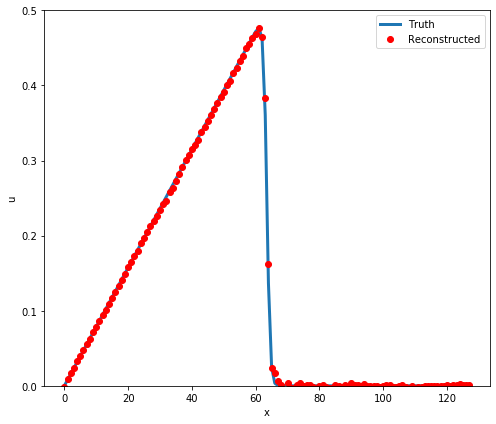

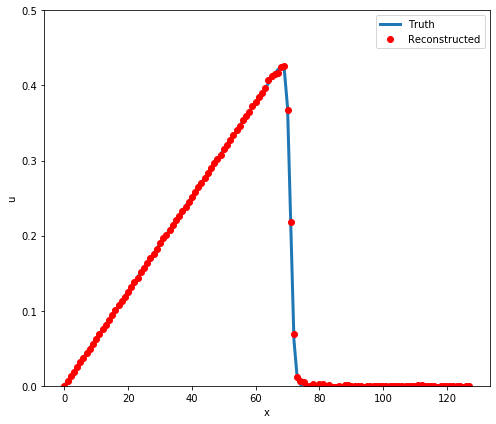

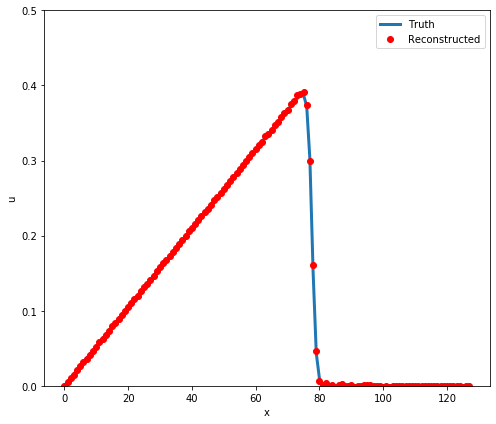

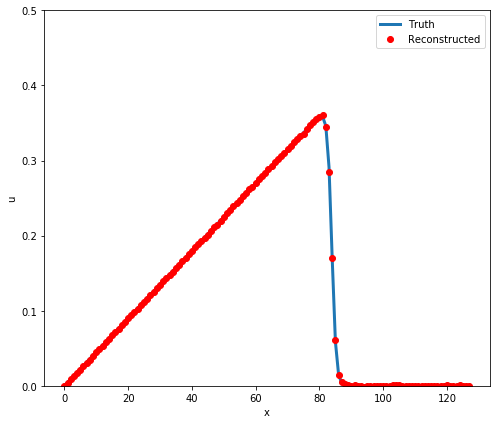

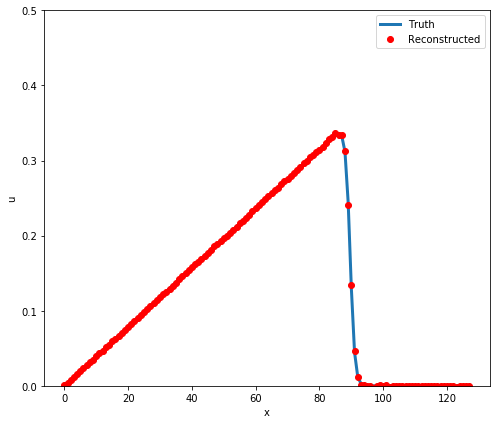

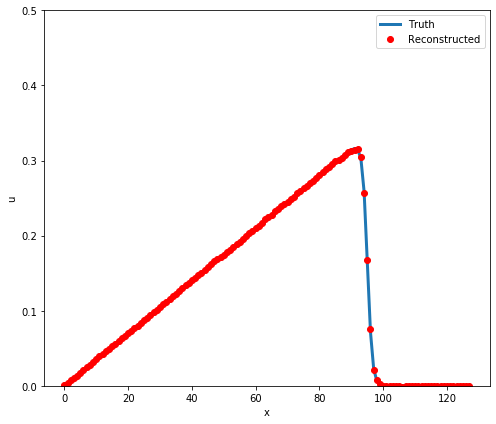

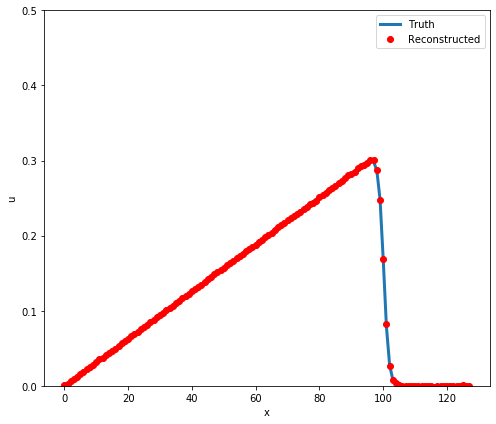

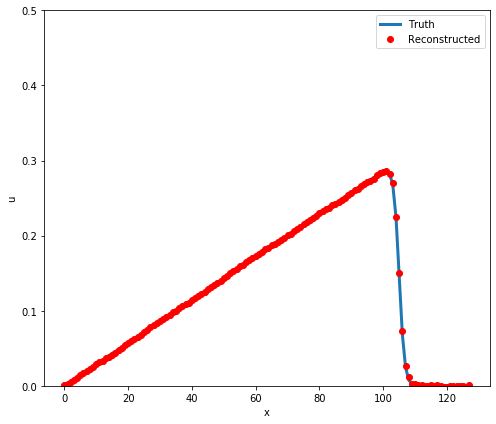

In [12]:
import matplotlib.pyplot as plt
model.load_weights(weights_filepath)
recoded_1 = model.predict(snapshots_train)[0]

for i in range(0,snapshots_train.shape[0],50):
    plt.figure(figsize=(7,6))
    plt.plot(snapshots_train[i,:,0:],label='Truth',linewidth=3)
    plt.plot(recoded_1[i,:,0:],'ro',label='Reconstructed')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.ylim((0,0.5))
    plt.tight_layout()
    plt.legend()
    plt.show()

### Check accuracy of Autoencoder+LSTM

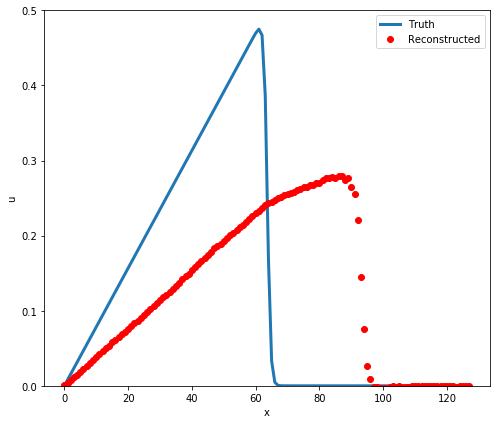

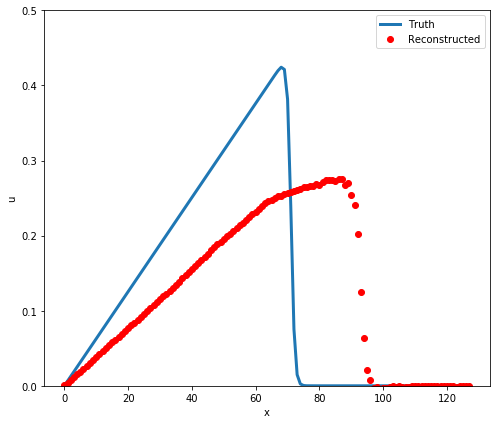

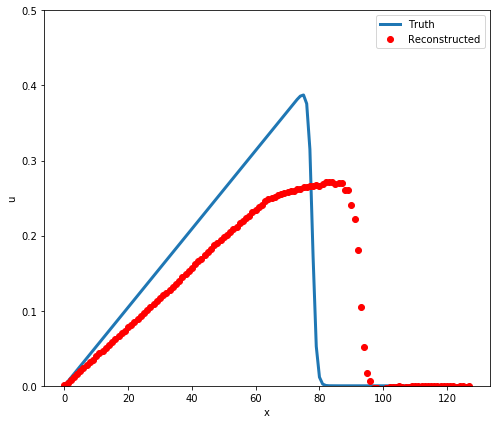

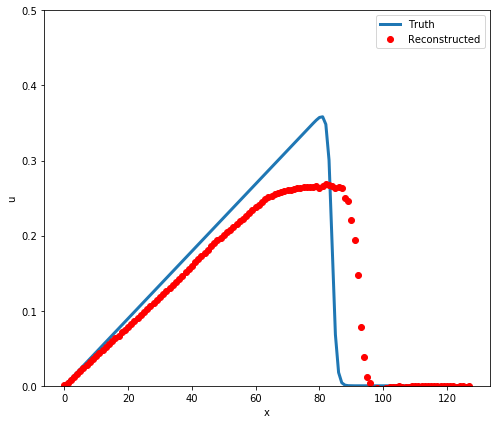

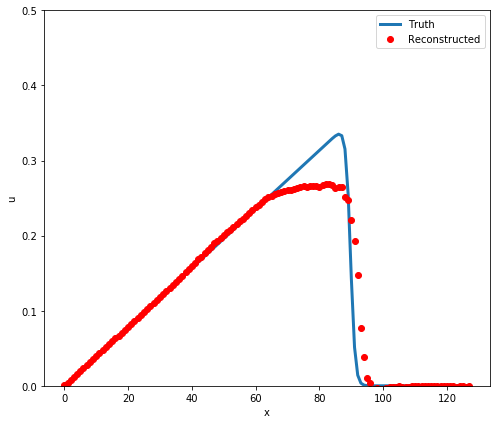

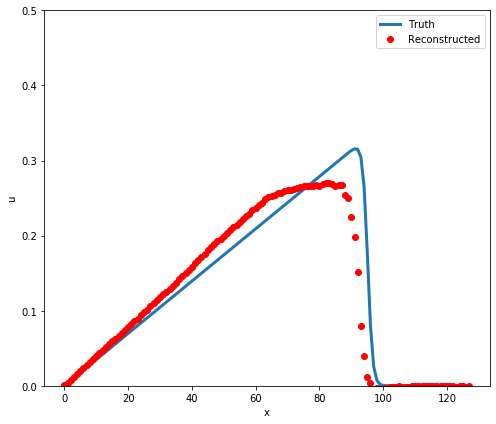

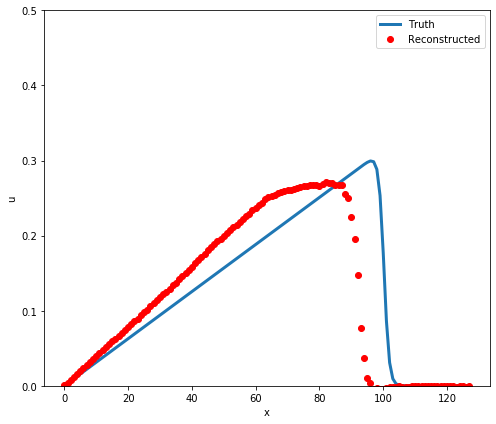

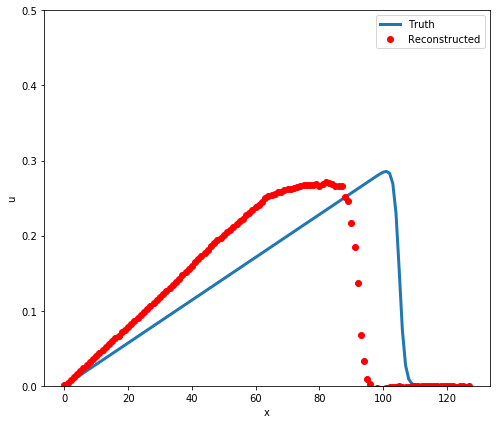

In [9]:
import matplotlib.pyplot as plt
model.load_weights(weights_filepath)
recoded_1 = model.predict(snapshots_train)[1]

for i in range(0,snapshots_train.shape[0],50):
    plt.figure(figsize=(7,6))
    plt.plot(snapshots_train[i+1,:,0:],label='Truth',linewidth=3)
    plt.plot(recoded_1[i,:,0:],'ro',label='Reconstructed')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.ylim((0,0.5))
    plt.tight_layout()
    plt.legend()
    plt.show()

### Get encoded representation

In [14]:
get_latent_representation = K.function([model.layers[0].input],
                                  [model.layers[12].output]) # Layer number 10 is the MaxPooling2D before entry to LSTM
layer_output = get_latent_representation([snapshots_train])[0]

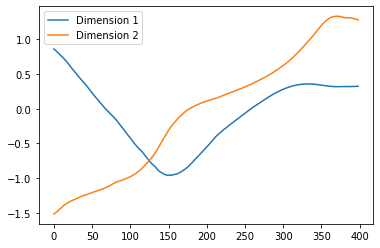

In [15]:
plt.figure()
plt.plot(layer_output[:,0],label='Dimension 1')
plt.plot(layer_output[:,1],label='Dimension 2')
plt.legend()
plt.show()

In [16]:
np.save('Latent.npy',layer_output)